# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
# Подключение к базе данных data-analyst-afisha
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
SELECT p.user_id
		, p.device_type_canonical
		, p.order_id
		, p.created_dt_msk AS order_dt
		, p.created_ts_msk AS order_ts
		, p.currency_code
		, p.revenue
		, p.tickets_count
		, (p.created_dt_msk::date - LAG(p.created_dt_msk::date,1, NULL) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)) AS days_since_prev
		, e.event_id
		, e.event_name_code AS event_name
    , e.event_type_main
    , p.service_name
		, r.region_name
		, c.city_name
FROM afisha.purchases AS p 
INNER JOIN afisha.events AS e USING (event_id)
LEFT JOIN afisha.city AS c USING (city_id)
LEFT JOIN afisha.regions AS r USING (region_id)
WHERE (p.device_type_canonical = 'desktop' OR
		p.device_type_canonical = 'mobile') AND
		e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [6]:
# Формирование датафрейма на основе выгрузки SQL
df = pd.read_sql_query(query, con=engine)

In [7]:
# Выводим первые пять строк датафрейма
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
# Выводим рандомные 1% строк датафрейма
df.sample(frac=0.01)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
9419,04b6911607ebb3e,mobile,1340961,2024-09-23,2024-09-23 22:14:00,rub,646.82,3,0.0,448257,7d712c23-e968-4099-ba47-12597d89e783,концерты,Облачко,Малиновоярский округ,Верховино
98022,46fc91dae91a53f,mobile,6560758,2024-09-27,2024-09-27 08:52:54,rub,45.71,2,0.0,436910,7aa3b63a-9cd7-401a-bd5b-401ef94c93ca,театр,Билеты без проблем,Североключевской округ,Зоречанск
1897,024dc5236465850,mobile,6652108,2024-07-14,2024-07-14 06:44:27,rub,263.34,4,1.0,528383,3d440d78-ae58-4a40-8fa5-ce102a440202,концерты,Лови билет!,Солнечноземская область,Глинополье
233968,c939f21e7986fad,mobile,8492274,2024-08-22,2024-08-22 15:18:05,rub,443.48,4,0.0,264638,bdeb1f43-a776-4ce8-9454-6b8de1944f9d,спорт,Билеты без проблем,Каменевский регион,Глиногорск
285524,fd4d47438ebb946,mobile,8256359,2024-07-23,2024-07-23 13:59:11,rub,1308.74,3,0.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Каменевский регион,Глиногорск
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149489,7d22e22c99ec66e,desktop,1269215,2024-06-15,2024-06-15 08:29:46,rub,220.89,3,0.0,525334,86b3f7ae-7d11-4ee0-8259-b8ed51ceddeb,концерты,Прачечная,Широковская область,Радужнополье
248666,d5f07a65694f995,mobile,8416004,2024-10-01,2024-10-01 11:25:12,rub,77.99,2,0.0,574431,d4344522-b7cf-4539-96c8-efece75e9b16,спорт,Билеты в руки,Медовская область,Радужсвет
236429,ca9ebd69d5405b9,mobile,3481712,2024-07-14,2024-07-14 22:50:17,rub,218.70,3,0.0,438445,202a9a89-29cd-4995-8dab-846679cc193e,концерты,Билеты в руки,Каменноярский край,Лесоярово
129867,64a9db20c6e7fe3,mobile,7162682,2024-07-18,2024-07-18 14:33:18,rub,174.59,4,2.0,390314,a2f54ed0-0081-47bc-97b2-74afdd4e25d4,другое,Билеты без проблем,Широковская область,Горнополец


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [9]:
# Выводим общую информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [10]:
# Описательные статистики, в т.ч. для категориальных переменных
df.describe(include='all')

/tmp/ipykernel_300/2896736239.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')
/tmp/ipykernel_300/2896736239.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
count,290611,290611,2.906110e+05,290611,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000,290611,290611,290611,290611,290611
unique,21933,2,NaN,153,280753,2,NaN,NaN,NaN,NaN,15248,7,36,81,352
top,0beb8fc0c0a9ce1,mobile,NaN,2024-10-01 00:00:00,2024-10-01 11:20:05,rub,NaN,NaN,NaN,NaN,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Билеты без проблем,Каменевский регион,Глиногорск
freq,10251,232490,NaN,7313,8,285542,NaN,NaN,NaN,NaN,3953,115276,63519,91058,89446
first,NaN,NaN,NaN,2024-06-01 00:00:00,2024-06-01 00:00:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2024-10-31 00:00:00,2024-10-31 23:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.326225e+06,NaN,NaN,NaN,625.584360,2.754311,3.222381,438019.834992,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,2.497551e+06,NaN,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,-90.760000,1.000000,0.000000,4436.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.163618e+06,NaN,NaN,NaN,116.850000,2.000000,0.000000,361772.000000,NaN,NaN,NaN,NaN,NaN


Итоговая выгрузка информации сервиса Яндекс.Афиша за период с 01.06.2024 по 31.10.2024 состоит из `290611 строк` и `15 столбцов`, пропуски содержатся только в поле `days_since_prev` (количество дней от предыдущей покупки пользователя).

Количество уникальных пользователей сервиса составляет 21933 пользователя, при этом имеется один пользователь `user_id = '0beb8fc0c0a9ce1'`, который совершил 10251 заказов. Заказы преимущественно совершались `с телефона` (232490 заказа из всей выборки) и оплачивались `российскими рублями` (285542 заказа - rub). Наиболее части пользователи приобретали билеты `на концерты` (115276 заказов). Наиболее популярный билетный оператор - `Билеты без проблем` (63519 заказов).

В целом, типы данных корректно отражают информацию, содержащуюся в столбцах. Вместе с тем, в целях оптимизации кода, можно заменить типы данных в следующих столбцах:
- `order_id`,
- `tickets_count`,
- `event_id`.

В столбце `days_since_prev` значения приведены в целых числах, но в связи с наличием значений **None**, тип данных `float64`. Значение None в данном столбце означает количество **полных** дней между текущей и предыдущей покупкой, у пользователей, у которых имеются несколько заказов в один день, значения в столбце **0**.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [11]:
# Формируем датафрейм с информацией о курсах казахстанских тенге
df_kzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
# Преобразовывваем тип данных даты в датафрейме с курсами в datetime64
df_kzt['data'] = df_kzt['data'].astype('datetime64[ns]')

In [13]:
# Фильтруем первоначальный датафрейм по валюте платежа - kzt
df_new = df[df['currency_code']=='kzt']

# Объединяем отфильтрованый датафрейм с датафреймом, содержащим имформацию о курсах валюты.
df_new = df_new.merge(df_kzt, left_on='order_dt', right_on='data', how = 'inner')

In [14]:
# Переводим сумму выручки по заказам оплаченным в казахстанских тенге в российские рубли
df_new['revenue_rub'] = df_new['revenue'] * df_new['curs'] / df_new['nominal']

In [15]:
# В целях дальнейшего объединения первоначального датафрейма с новым,
# в котором имеется информация о выручке в рублях, фильтруем столбцы нового датафрейма
df_rub = df_new.loc[:,['order_id','revenue_rub']]

In [16]:
# Объединяем датафреймы
df_end = df.merge(df_rub, on='order_id', how='left')

In [17]:
# Заполняем значения в столбце revenue_rub для выручки в российских рублях
revenue = df['revenue']
df_end['revenue_rub'] = df_end['revenue_rub'].fillna(revenue)
df_end

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск,1448.36
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск,965.57
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск,178.95
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка,661.53


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [18]:
# Проверяем итоговый датафрейм на пропуски и типы данных
df_end.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Пропуски встречаются только в столбце `days_since_prev`.

In [19]:
# Преобразовываем типы данных
#(столбцы с типом данных даты и временя были привены к datetime64[ns]
# в процессе приведения выручки к единой валюте - российский рубль)
df_end['order_id'] = pd.to_numeric(df_end['order_id'], downcast = 'integer')
df_end['tickets_count'] = pd.to_numeric(df_end['tickets_count'], downcast = 'integer')
df_end['event_id'] = pd.to_numeric(df_end['event_id'], downcast = 'integer')

In [20]:
# Округляем значения в столбцах revenue и revenue_rub до двух знаков.
# (округления после преобразования типа данных во float32 не происходит)
# Нашла информацию в интернете, что данная проблема имеется, корректное округление для float64
df_end['revenue'] = df_end['revenue'].round(2)
df_end['revenue_rub'] = df_end['revenue_rub'].round(2)

In [21]:
# Меняем регистр на наименованиях сервисов продажи билетов, наименованиях регионов и городов,
# в целях дальшейней проверки на дубликаты
df_end['service_name'] = df_end['service_name'].str.lower()
df_end['region_name'] = df_end['region_name'].str.lower()
df_end['city_name'] = df_end['city_name'].str.lower()

In [22]:
# Явных дубликатов не установлено, так как order_id - PK.

# Проверяем дубликаты - 1:
# Пользователь в одно и тоже время (до секунд) создал заказы одинакового количества билетов
# на одно мероприятие у одного билетного оператора с одного типа устройства
df_end_duplicated_1 = df_end[df_end.duplicated(['user_id','device_type_canonical','order_ts','tickets_count','event_id','service_name'])==True]

# Подсчитываем количество строк найденных дубликатов
count_rows = df_end_duplicated_1.shape[0]
f'Обнаружено дублирующихся строк {count_rows}.'

'Обнаружено дублирующихся строк 40.'

In [23]:
# Удаляем найденные дубликаты
df_finish = df_end.drop_duplicates(['user_id','device_type_canonical','order_ts','tickets_count','event_id','service_name'])

In [24]:
# Проверяем дубликаты - 2:
# В очищенном датафрейме (после 1 проверки дубликатов и их удалении)
# Пользователь в одно и тоже время (до секунд) создал заказы
# на одно меропритие у одного билетного оператора с одного типа устройства
df_finish_duplicated_2 = df_finish[df_finish.duplicated(['user_id','device_type_canonical','order_ts','event_id','service_name'])==True]

# Подсчитываем количество строк найденных дубликатов
count_rows = df_finish_duplicated_2.shape[0]
f'Обнаружено дублирующихся строк {count_rows}.'

'Обнаружено дублирующихся строк 72.'

In [25]:
# Выявленные возможные дубликаты сгруппируем по пользователям и времени создания заказов,
# а также отфильтруем по количеству дублирующихся строк 
df_user_id = df_finish_duplicated_2.groupby(['user_id','order_ts']).count().reset_index()
df_user_id[df_user_id['order_id']>1]

,user_id,order_ts,device_type_canonical,order_id,order_dt,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
68,fd4d47438ebb946,2024-06-19 15:40:56,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [26]:
# Выведем данные по пользователю, который сформировал в одно время три заказа на одно мероприятие
# с разным количеством билетов
df_finish[(df_finish['user_id'] == 'fd4d47438ebb946') & (df_finish['order_ts'] == '2024-06-19 15:40:56')]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
285375,fd4d47438ebb946,desktop,8547867,2024-06-19,2024-06-19 15:40:56,rub,1319.43,4,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,1319.43
285379,fd4d47438ebb946,desktop,8548099,2024-06-19,2024-06-19 15:40:56,rub,989.57,3,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,989.57
285384,fd4d47438ebb946,desktop,8547954,2024-06-19,2024-06-19 15:40:56,rub,659.71,2,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,659.71


**Поиск дубликатов**

По результатам анализа явных дубликатов не выявлено, так как каждый номер заказа индивидуален. Вместе с тем, при анализе неявных дубликатов установлено следующее:

1. Установлено **40 строк дубликатов** при условии, что пользователь в одно время (до секунд) совершил заказы одинакового количества билетов на одно меропритие у одного билетного оператора с одного типа устройства (данные дубликаты были удалены).


2. Установлено **72 строки возможных дубликатов** при условии, что пользователь в одно время (до секунд) совершил заказы на одно меропритие у одного билетного оператора с одного типа устройства (**данными пользователям в одно время были созданы по 2 заказа на одно мероприятие на разное количество билетов в каждом из заказов**), в т.ч. имеется один пользователь (`user_id = fd4d47438ebb946`), который в одно время сформирал 3 заказа на одно мероприятие (отличаются только количество билетов в заказах). Данные возможные дубликаты принято решение не удалять и продолжить их анализировать.

In [27]:
# Рассчитаем статистические меры по количеству билетов в заказе
avg = df_finish['tickets_count'].mean()
print(f'Среднее арифметическое {avg}')
median = df_finish['tickets_count'].median()
print(f'Медиана {median}')
mode = df_finish['tickets_count'].mode()
print(f'Мода {mode}')
max = df_finish['tickets_count'].max()
print(f'Максимальное значение {max}')
min = df_finish['tickets_count'].sort_values(ascending =False).min()
print(f'Минимальное значение {min}')
var = df_finish['tickets_count'].var()
print(f'Дисперсия {var}')
std = df_finish['tickets_count'].std()
print(f'Стандартное отклонение {std}')

Среднее арифметическое 2.7543182217082918
Медиана 3.0
Мода 0    3
dtype: int8
Максимальное значение 57
Минимальное значение 1
Дисперсия 1.3703041236580225
Стандартное отклонение 1.1705998990509192


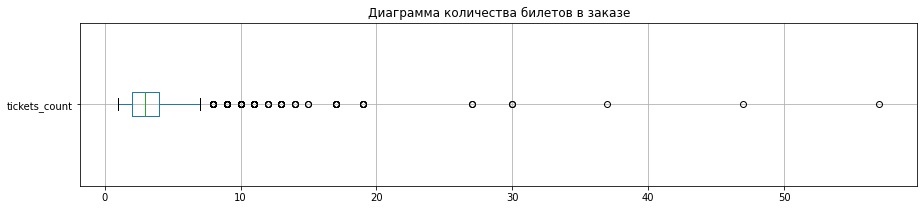

In [28]:
# Импортируем библиотеку matplotlib и строим диаграмму размаха
import matplotlib.pyplot as plt
boxplot = df_finish.boxplot('tickets_count',vert = False, figsize = (15,3))
boxplot.set_title("Диаграмма количества билетов в заказе")
plt.show()

In [29]:
# Подсчитываем количество заказов, в которых количество билетов более 10 штук в заказе
count_tickets_upper_10 = df_finish[df_finish['tickets_count'] > 10].shape[0]

print(f'Заказы с количеством билетов более 10 - {count_tickets_upper_10} заказов.')

Заказы с количеством билетов более 10 - 48 заказов.


**Статистические показатели по количеству билетов в заказе** характеризуются следующим:
- минимальное количество билетов в заказе - 1 , максимальное - 57;
- среднее количество билетов в заказе - ~3;
- на графике размаха по количеству билетов в заказе наблюдаются правосторонняя асимметрия (более 10 билетов в заказе содержат 48 заказов из всего объема исследования).

In [30]:
# Рассчитаем статистические меры по размеру выручки в рублях
avg = df_finish['revenue_rub'].mean()
print(f'Среднее арифметическое {avg}')
median = df_finish['revenue_rub'].median()
print(f'Медиана {median}')
mode = df_finish['revenue_rub'].mode()
print(f'Мода {mode}')
max = df_finish['revenue_rub'].max()
print(f'Максимальное значение {max}')
min = df_finish['revenue_rub'].sort_values(ascending =False).min()
print(f'Минимальное значение {min}')
var = df_finish['revenue_rub'].var()
print(f'Дисперсия {var}')
std = df_finish['revenue_rub'].std()
print(f'Стандартное отклонение {std}')

Среднее арифметическое 555.5859802595579
Медиана 351.14
Мода 0    0.0
dtype: float64
Максимальное значение 81174.54
Минимальное значение -90.76
Дисперсия 766550.6328583385
Стандартное отклонение 875.528773289798


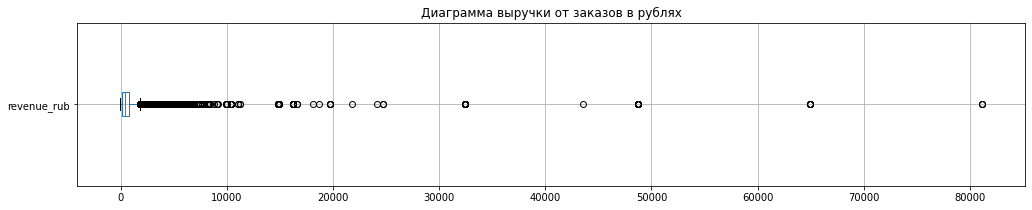

In [31]:
# Строим диаграмму размаха по объему выручки в рублях
boxplot = df_finish.boxplot('revenue_rub',vert = False, figsize = (17,3))
boxplot.set_title("Диаграмма выручки от заказов в рублях")
plt.show()

In [32]:
# Подсчитываем количество заказов, по которым размер выручки составляет более 5000 рублей
count_tickets_upper_10 = df_finish[df_finish['revenue_rub'] > 5000].shape[0]

print(f'Количество заказов с размером выручки более 5000 рублей - {count_tickets_upper_10} заказов.')

Количество заказов с размером выручки более 5000 рублей - 299 заказов.


**Статистические показатели по размеру выручки** характеризуются следующим:
- минимальный объем выручки отрицательный и составляет - (-90,76 рублей) , максимальный - 81174,54 рубля;
- средний размер выручки от заказа составляет 555,59 рублей;
- на графике размаха выручки от заказов в рублях наблюдается правосторонняя асимметрия (выручка более чем 5000 рублей за заказ формируется примерно по 300 заказам).

In [33]:
# Фильтруем выручку по 99 процентилю
outliers = df_end['revenue_rub'].quantile(0.99)
df_end = df_end.loc[df_end['revenue_rub'] < outliers]
df_end

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,каменевский регион,глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,каменевский регион,глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,каменевский регион,глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,североярская область,озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,озернинский край,родниковецк,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,весь в билетах,каменевский регион,глиногорск,1448.36
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,весь в билетах,каменевский регион,глиногорск,965.57
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,прачечная,каменевский регион,глиногорск,178.95
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,билеты без проблем,широковская область,ягодиновка,661.53


In [34]:
# Вычисляем объем итогового датафрейма
f'Из {len(df)} строк изначального датасета для анализа выбраны {len(df_end)}'

'Из 290611 строк изначального датасета для анализа выбраны 287604'

In [35]:
# Подсчет количества удаленных строк
str_del = df.shape[0] - df_end.shape[0]
str_del

3007

In [36]:
# Процент удаленных строк
str_del / df.shape[0] * 100

1.0347165110749421

По результатам предобработки данных был сформирован новый столбец, в котором отражается размер выручки с заказа в российских рублях. Значения в первоначальных данных включали информацию также о размере выручки в казахстанских тенге, которые были сконвертированы по текущему курсу на дату формирования заказа.

Была проведена оптимизация типов данных, в том числе в целях уменьшения размерности типов. Строковые данные были приведены к нижнему регистру в целях анализа дубликатов.

Удалены дубликаты в объеме 40 строк, а также датафрейм был отфильтрован по 99 процентилю по размеру выручки с заказа.
Данные по количеству билетов в заказе, также как и размеру выручки с заказа характеризуются правосторонней асимметрией.

Минимальное количество билетов в заказе 1, медиана равна 3, при этом макисмальное количество билетов в заказе равно 57 (1 заказ).

Минимальный размер выручки с заказа отрицальный и составляет (-90,76) рублей, медиана - 351,14 рублей, при этом максимальное значение - 811174,54 рубля (1 заказ с 57 билетами). *Отрицальный размер выручки заказа возможен в случае возврата заказа.*

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [37]:
# Сортируем датафрейм по времени создания заказа
df_end = df_end.sort_values('order_ts')

# Строим профиль пользователя
df_profile = df_end.groupby('user_id').agg(first_order_dt = ('order_dt','min'),
                                           last_order_dt = ('order_dt','max'),
                                           first_device_type = ('device_type_canonical','first'),
                                           first_region = ('region_name','first'),
                                           first_service_name = ('service_name','first'),
                                           first_event_type = ('event_type_main','first'),
                                           order_count = ('order_id','count'),
                                           avg_revenue_rub = ('revenue_rub','mean'),
                                           avg_tickets_count = ('tickets_count','mean'),
                                           avg_days_since_prev = ('days_since_prev','mean'))

In [38]:
# Сбрасываем индексы и выводим получившийся датафрейм с профилем пользователя
df_profile = df_profile.reset_index()
df_profile

,user_id,first_order_dt,last_order_dt,first_device_type,first_region,first_service_name,first_event_type,order_count,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.000
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.000
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.000
...,...,...,...,...,...,...,...,...,...,...,...
21843,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,каменевский регион,мой билет,другое,9,688.043333,2.555556,13.375
21844,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,каменевский регион,билеты без проблем,стендап,2,850.995000,2.500000,74.000
21845,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,каменевский регион,билеты без проблем,концерты,33,557.908485,2.787879,4.125
21846,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,широковская область,билеты без проблем,стендап,1,661.530000,2.000000,NaN


In [39]:
# Добавляем бинарные признаки
# пользователь совершил 2 и более заказов
df_profile['is_two'] = df_profile['order_count'] >= 2
# пользователь совершил 5 и более заказов
df_profile['is_five'] = df_profile['order_count'] >= 5

df_profile

,user_id,first_order_dt,last_order_dt,first_device_type,first_region,first_service_name,first_event_type,order_count,avg_revenue_rub,avg_tickets_count,avg_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.000,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.000,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21843,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,каменевский регион,мой билет,другое,9,688.043333,2.555556,13.375,True,True
21844,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,каменевский регион,билеты без проблем,стендап,2,850.995000,2.500000,74.000,True,False
21845,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,каменевский регион,билеты без проблем,концерты,33,557.908485,2.787879,4.125,True,True
21846,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,широковская область,билеты без проблем,стендап,1,661.530000,2.000000,NaN,False,False


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [40]:
# Рассчитываем показатели на основании данных о профилях пользователей:
user_count = df_profile['user_id'].count()
print(f'Общее число пользователей в выборке: {user_count}')

avg_revenue = df_profile['avg_revenue_rub'].mean().round(2)
print(f'Средняя выручка с одного заказа по всем пользователям: {avg_revenue}')

user_order_upper_2 = df_profile['is_two'].mean()
print(f'Доля пользователей, совершивших 2 и более заказов: {user_order_upper_2}')

user_order_upper_5 = df_profile['is_five'].mean()
print(f'Доля пользователей, совершивших 5 и более заказов: {user_order_upper_5}')

Общее число пользователей в выборке: 21848
Средняя выручка с одного заказа по всем пользователям: 543.39
Доля пользователей, совершивших 2 и более заказов: 0.6171274258513365
Доля пользователей, совершивших 5 и более заказов: 0.29004943244232884


In [41]:
# Рассчитываем статистические показатели на основании данных о профилях пользователей:
orders_count = df_profile['order_count'].sum()
print(f'Общее число заказов всех пользователей: {orders_count}')

avg_orders_count = orders_count / user_count
print(f'Среднее число заказов на одного пользователя: {avg_orders_count}')

orders_count_max = df_profile['order_count'].max()
print(f'Максимальное количество заказов у пользователя: {orders_count_max}')

avg_tickets = df_profile['avg_tickets_count'].mean()
print(f'Среднее количество билетов в заказе: {avg_tickets}')

avg_days = df_profile['avg_days_since_prev'].mean()
print(f'Среднее количество дней между покупками: {avg_days}')

Общее число заказов всех пользователей: 287604
Среднее число заказов на одного пользователя: 13.163859392164042
Максимальное количество заказов у пользователя: 10175
Среднее количество билетов в заказе: 2.74291824220138
Среднее количество дней между покупками: 15.863060326878319


In [42]:
# Статистические показатели по профилю пользователя методом describe
df_profile.describe()

,order_count,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
count,21848.000000,21848.000000,21848.000000,13510.000000
mean,13.163859,543.385096,2.742918,15.863060
std,121.624128,429.734855,0.913389,22.321574
min,1.000000,-10.770000,1.000000,0.000000
25%,1.000000,212.755000,2.000000,1.000000
50%,2.000000,466.845079,2.750000,8.000000
75%,5.000000,763.370625,3.076923,20.428571
max,10175.000000,2624.810000,11.000000,148.000000


**Анализ среднего количества заказов пользователей:**

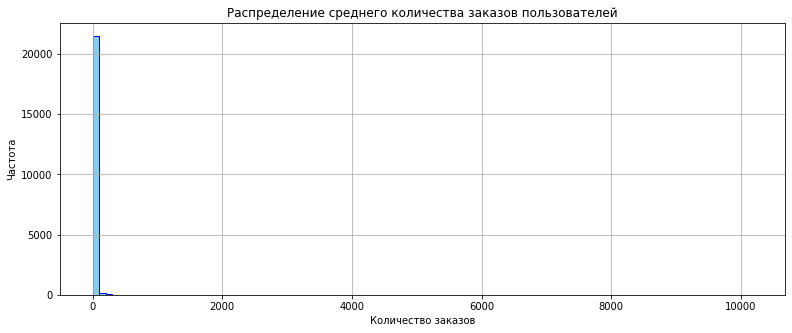

In [43]:
# Построим гистрограмму распределения среднего количества заказов пользователей
plt.figure(figsize=(13,5))
plt.hist(df_profile['order_count'],
        bins=100,
        alpha=1,
        color='skyblue',
        edgecolor='blue')
plt.title ('Распределение среднего количества заказов пользователей')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

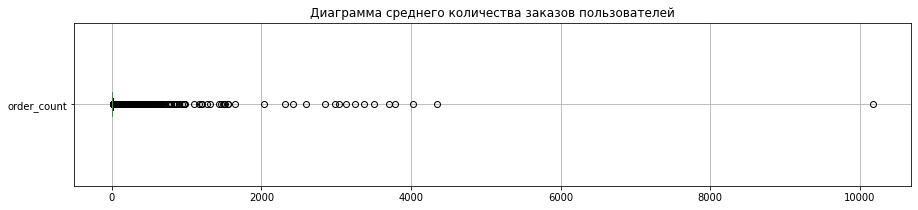

In [44]:
# Построим "ящик с усами" по среднему количеству заказов пользователей
boxplot = df_profile.boxplot('order_count',vert = False, figsize = (15,3))
boxplot.set_title("Диаграмма среднего количества заказов пользователей")
plt.show()

In [45]:
# Пользователь с максимальным количеством заказов
df_profile[df_profile['order_count']==df_profile['order_count'].max()]

,user_id,first_order_dt,last_order_dt,first_device_type,first_region,first_service_name,first_event_type,order_count,avg_revenue_rub,avg_tickets_count,avg_days_since_prev,is_two,is_five
980,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,mobile,североярская область,билеты в руки,концерты,10175,503.900268,2.862506,0.014842,True,True


**Анализ размера средней выручки по заказам пользователей:**

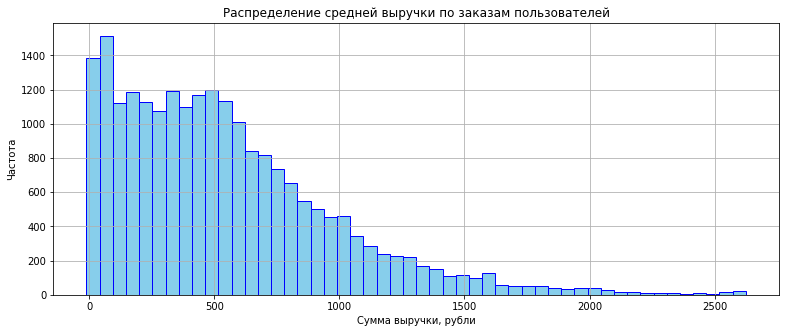

In [46]:
# Построим гистрограмму распределения средней выручки по заказам пользователей
plt.figure(figsize=(13,5))
plt.hist(df_profile['avg_revenue_rub'],
        bins=50,
        alpha=1,
        color='skyblue',
        edgecolor='blue')
plt.title ('Распределение средней выручки по заказам пользователей')
plt.xlabel('Сумма выручки, рубли')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

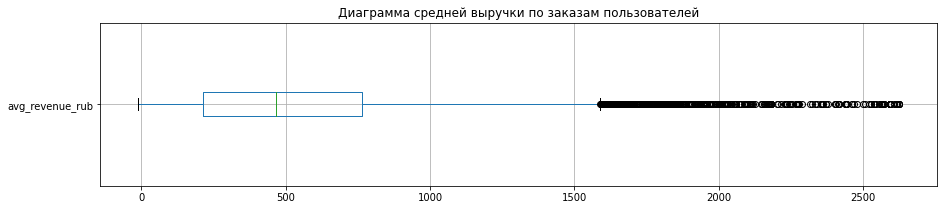

In [47]:
# Построим "ящик с усами" по средней выручки по заказам пользователей
boxplot = df_profile.boxplot('avg_revenue_rub',vert = False, figsize = (15,3))
boxplot.set_title("Диаграмма средней выручки по заказам пользователей")
plt.show()

**Анализ среднего количества дней между заказами пользователей:**

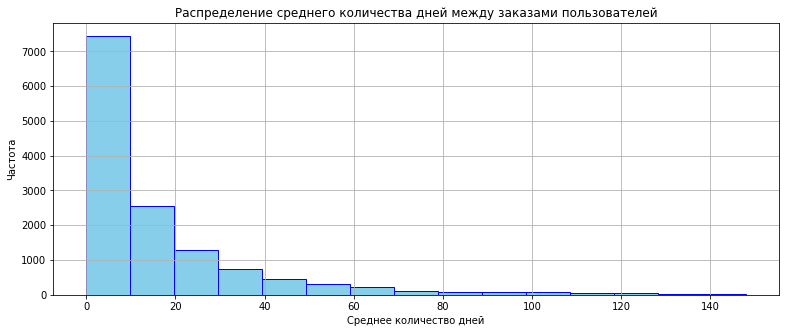

In [48]:
# Построим гистрограмму распределения среднего количества дней между заказами пользователей
plt.figure(figsize=(13,5))
plt.hist(df_profile['avg_days_since_prev'],
        bins=15,
        alpha=1,
        color='skyblue',
        edgecolor='blue')
plt.title ('Распределение среднего количества дней между заказами пользователей')
plt.xlabel('Среднее количество дней')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

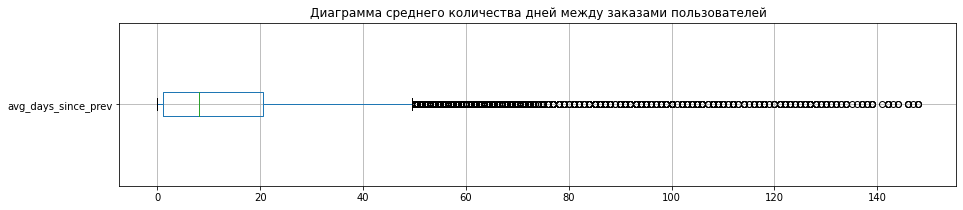

In [49]:
# Построим "ящик с усами" по среднему количеству дней между заказами пользователей
boxplot = df_profile.boxplot('avg_days_since_prev',vert = False, figsize = (15,3))
boxplot.set_title("Диаграмма среднего количества дней между заказами пользователей")
plt.show()

**Анализ среднего количества билетов в заказах пользователей:**

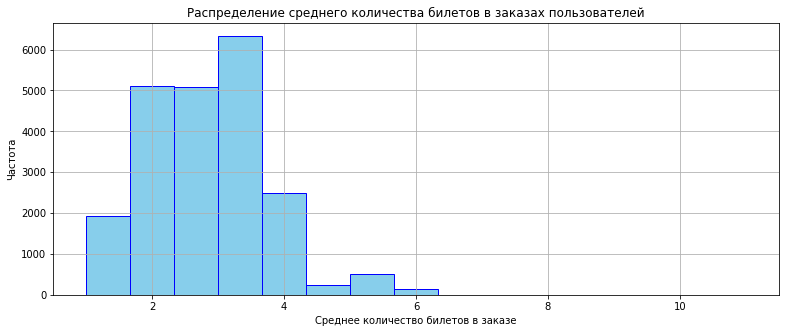

In [50]:
# Построим гистрограмму распределения среднего количества билетов в заказах пользователей
plt.figure(figsize=(13,5))
plt.hist(df_profile['avg_tickets_count'],
        bins=15,
        alpha=1,
        color='skyblue',
        edgecolor='blue')
plt.title ('Распределение среднего количества билетов в заказах пользователей')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

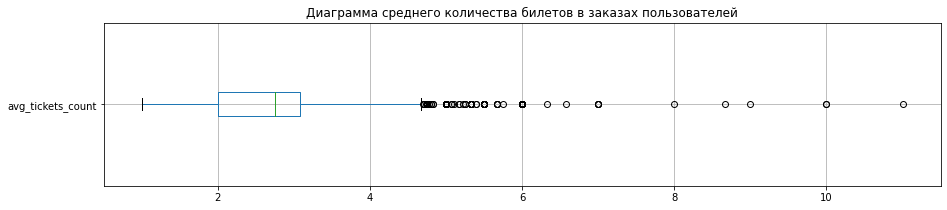

In [51]:
# Построим "ящик с усами" по среднему количеству билетов в заказах пользователей
boxplot = df_profile.boxplot('avg_tickets_count',vert = False, figsize = (15,3))
boxplot.set_title("Диаграмма среднего количества билетов в заказах пользователей")
plt.show()

In [52]:
# Вычислим межквартильный размах
q1_revenue = 2.0
q3_revenue = 3.08
IQR = q3_revenue - q1_revenue
lower = q1_revenue - 1.5 * IQR
upper = q3_revenue + 1.5 * IQR
print(f'Нижний порог выбросов {lower}')
print(f'Верхний порог выбросов {upper}')

Нижний порог выбросов 0.3799999999999999
Верхний порог выбросов 4.7


In [53]:
# Рассчитаем величину среднего количества билетов характерную 97 процентилю
avg_tickets_97 = df_profile['avg_tickets_count'].quantile(0.97)
avg_tickets_97

5.0

In [54]:
# Фильтруем датафрейм по 97 процентилю по среднему количеству билетов
df_profile_filter = df_profile.loc[df_profile['avg_tickets_count'] < avg_tickets_97]

In [55]:
# Выводим статистические данные по отфильтрованному датафрейму
df_profile_filter.describe()

,order_count,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
count,21187.000000,21187.000000,21187.000000,13384.000000
mean,13.531741,534.162041,2.663336,15.935373
std,123.488597,415.655799,0.799920,22.323173
min,1.000000,-10.770000,1.000000,0.000000
25%,1.000000,211.615000,2.000000,1.051769
50%,2.000000,463.390000,2.700000,8.121324
75%,6.000000,753.290000,3.000000,20.500000
max,10175.000000,2624.810000,4.833333,148.000000


In [56]:
orders_count = df_profile_filter['order_count'].sum()
print(f'Общее число заказов всех пользователей: {orders_count}')

Общее число заказов всех пользователей: 286697


In [57]:
# Вычисляем объем отбильтрованных данных
f'Из {len(df_profile)} строк датасета о профилях пользователей для анализа выбраны {len(df_profile_filter)}'

'Из 21848 строк датасета о профилях пользователей для анализа выбраны 21187'

In [58]:
# Подсчет количества удаленных строк
str_del = df_profile.shape[0] - df_profile_filter.shape[0]
str_del

661

In [59]:
# Процент удаленных строк
str_del / df_profile.shape[0] * 100

3.025448553643354

**По результатам анализа информации о профилях пользователей установлено следующее**:
- количество уникальных пользователей - 21848, после проведения фильтрации данных по среднему количеству билетов в заказе (по 97 процентилю) - 21187;


- общее количество заказов, сформированных пользователями - 287604 заказа, при этом среднее количество заказов, приходящихся на одного пользователя ~13 заказов; после фильтрации общее количество заказов - 286697, среднее количесвтво заказов на пользователя существенно не изменилось;


- имеется пользователь `0beb8fc0c0a9ce1`, сформировавший аномальное количество заказов - 10175 заказов. Вместе с тем, средняя выручка по заказам данного пользователя (503,9 рублей) сопоставима со средним размером выручки по всем пользователям (543,39 рублей), а среднее количество билетов в заказах пользователя (2,86) сопоставимо со средним количеством билетов в заказах всех пользователей (2,74). С учетом изложенного, данное аномальное значение не требует исключения в целях дальнейшего анализа;


- средний объем средней выручки по заказам пользователей равен 543,39 рублей. Минимальное значение средней выручки отрицательно (-10,77 рублей), что может свидетельствовать о возврате заказа. Максимальное значение средней выручки (2624,81 рублей) является аномальным выбросом. Гистограмма имеет правостороннюю асимметрию.


- среднее количество дней между заказами пользователей ~16 дней. Минимальное значение 0, что свидетельствует о наличии у пользователя более 1 заказа, при этом каждый последующий заказ пользователь совершал менее чем через сутки. Максимальное значение 148 дней. Для пользователей, которые совершили только один заказ, данные показатель соответствсует None.


- среднее количество билетов в заказе пользователя составляет 2,74. Минимальное - 1 билет, максимальное - 11 билетов, что является аномальным выбросом. По результатам рассматрения диаграмы размаха, а также с учетом расчета межквартильного инервала IQR, верхний порог выбросов соответствует значению 4.7. С учетом низкой частоты заказов с количеством билетов более 6 (что наблюдается на гистограмме), а также рассчитанным верхним порогом, которому соответствует 97 процентиль данных, **считаю необходимым провести фильтрацию по 97 процентилю**.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [60]:
# Группировка пользователей по типу их первого мероприятия
df_first_event = df_profile_filter.groupby(['first_event_type'])['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
df_first_event['share'] = df_first_event['user_id'] / len(df_profile_filter)
df_first_event

,first_event_type,user_id,share
2,концерты,9446,0.445839
1,другое,5259,0.248218
5,театр,4153,0.196016
4,стендап,1081,0.051022
3,спорт,747,0.035257
0,выставки,411,0.019399
6,ёлки,90,0.004248


In [61]:
# Группировка пользователей по типу устройства, с которого совершена первая покупка
df_first_device = df_profile_filter.groupby(['first_device_type'])['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
df_first_device['share'] = df_first_device['user_id'] / len(df_profile_filter)
df_first_device

,first_device_type,user_id,share
1,mobile,17574,0.829471
0,desktop,3613,0.170529


In [62]:
# Группировка пользователей по региону проведения мероприятия из первого заказа
df_first_region = df_profile_filter.groupby(['first_region'])['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
df_first_region['share'] = df_first_region['user_id'] / len(df_profile_filter)
df_first_region

,first_region,user_id,share
23,каменевский регион,6951,0.328079
60,североярская область,3657,0.172606
77,широковская область,1187,0.056025
45,озернинский край,654,0.030868
41,малиновоярский округ,518,0.024449
...,...,...,...
17,залесский край,2,0.000094
70,тихогорская область,2,0.000094
5,верхозёрский край,1,0.000047
66,сосноводолинская область,1,0.000047


In [63]:
# Группировка пользователей по билетному оператору, продавшему билеты на первый заказ
df_first_service = df_profile_filter.groupby(['first_service_name'])['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
df_first_service['share'] = df_first_service['user_id'] / len(df_profile_filter)
df_first_service

,first_service_name,user_id,share
3,билеты без проблем,5059,0.238778
22,мой билет,2890,0.136404
19,лови билет!,2760,0.130269
4,билеты в руки,2519,0.118894
23,облачко,2163,0.102091
7,весь в билетах,1268,0.059848
20,лучшие билеты,1141,0.053854
24,прачечная,568,0.026809
17,край билетов,445,0.021003
12,дом культуры,344,0.016236


В рамках сегментов пользователи распределены **неравномерно**:
- **по типу их первого мероприятия**: наибольшее количество пользователей в качестве первого мероприятия приобретают билеты на `концерт` (44,6% всех пользователей), наименьшее - на `ёлки` (0,4%). Вместе с тем, ёлки - сезонный тип мероприятия, период выборки для анализа данных билетов нерепрезентативен.
- **по типу устройства, с которого совершена первая покупка**: наибольшее количество пользователей создают свой первый заказ с `мобильного телефона` (82,9% всех пользователей), наименьшее - с `компьютера` (17,1%).
- **по региону проведения мероприятия из первого заказа**: наибольшее количество пользователей в качестве первого заказа выбирают мероприятия, проходящие в `Каменевском регионе` (32,8% всех пользователей), наименьшее - `Верхозёрский край`, `Сосноводолинская область` и  `Яснопольский округ` (0,005%).
- **по билетному оператору, продавшему билеты на первый заказ**: наибольшее количество пользователей приобретали билеты через оператора `Билеты без проблем` (23,9% всех пользователей), наименьшее -`Зе бест!` (0,005%).

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [64]:
# Рассчитываем долю вернувшихся пользователей по типу их первого мероприятия
grouped_event = df_profile_filter.groupby(['first_event_type']).agg({'user_id': 'count',
                                                                     'is_two': 'sum'})
grouped_event['is_two_share'] = grouped_event['is_two'] / grouped_event['user_id']
grouped_event.sort_values(by='is_two_share', ascending=False)

,user_id,is_two,is_two_share
first_event_type,,,
театр,4153,2714,0.653503
выставки,411,267,0.649635
концерты,9446,5946,0.629473
стендап,1081,679,0.628122
другое,5259,3262,0.620270
ёлки,90,53,0.588889
спорт,747,438,0.586345


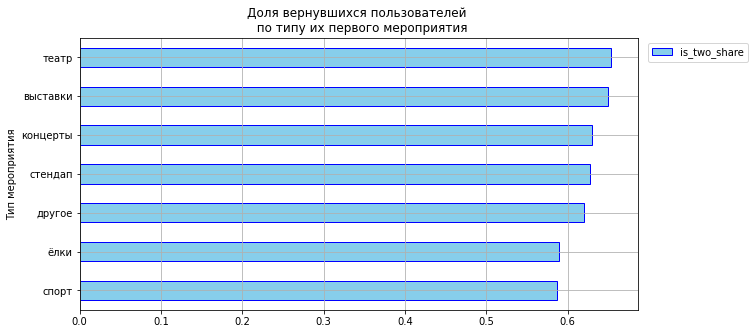

In [65]:
# Визуализируем долю вернувшихся пользователей по типу их первого мероприятия
grouped_event['is_two_share'].sort_values().plot(kind='barh',
                                 title=f'Доля вернувшихся пользователей \n  по типу их первого мероприятия',
                                 color='skyblue',
                                 edgecolor='blue',
                                 legend=True,
                                 ylabel='',
                                 xlabel='Тип мероприятия',
                                 rot=0,
                                 figsize=(10, 5))

plt.grid()
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

In [66]:
# Рассчитываем долю вернувшихся пользователей по типу устройства, с которого совершена первая покупка
grouped_device = df_profile_filter.groupby(['first_device_type']).agg({'user_id': 'count',
                                                                     'is_two': 'sum'})
grouped_device['is_two_share'] = grouped_device['is_two'] / grouped_device['user_id']
grouped_device.sort_values(by='is_two_share', ascending=False)

,user_id,is_two,is_two_share
first_device_type,,,
desktop,3613,2376,0.657625
mobile,17574,10983,0.624957


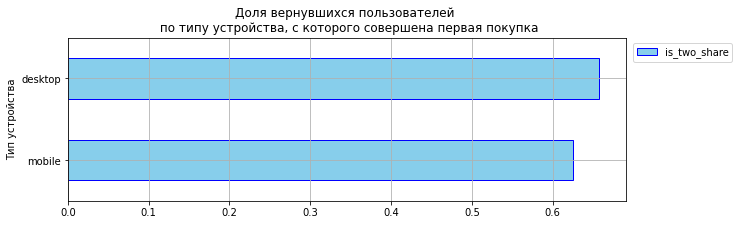

In [67]:
# Визуализируем долю вернувшихся пользователей по типу устройства, с которого совершена первая покупка
grouped_device['is_two_share'].sort_values().plot(kind='barh',
                    title=f'Доля вернувшихся пользователей \n по типу устройства, с которого совершена первая покупка',
                    color='skyblue',
                    edgecolor='blue',
                    legend=True,
                    ylabel='',
                    xlabel='Тип устройства',
                    rot=0,
                    figsize=(10, 3))

plt.grid()
plt.legend(bbox_to_anchor=(1.20, 1))
plt.show()

In [68]:
# Рассчитываем долю вернувшихся пользователей по региону проведения мероприятия их первого заказа
grouped_region = df_profile_filter.groupby(['first_region']).agg({'user_id': 'count',
                                                                     'is_two': 'sum'})
grouped_region['is_two_share'] = grouped_region['is_two'] / grouped_region['user_id']
grouped_region.sort_values(by='is_two_share', ascending=False)

,user_id,is_two,is_two_share
first_region,,,
верхозёрский край,1,1,1.000000
озернопольская область,27,25,0.925926
радужнопольский край,23,18,0.782609
горноземский регион,27,20,0.740741
лесостепной край,60,44,0.733333
...,...,...,...
теплоозёрский округ,3,1,0.333333
островогорский округ,3,1,0.333333
крутоводский регион,3,1,0.333333


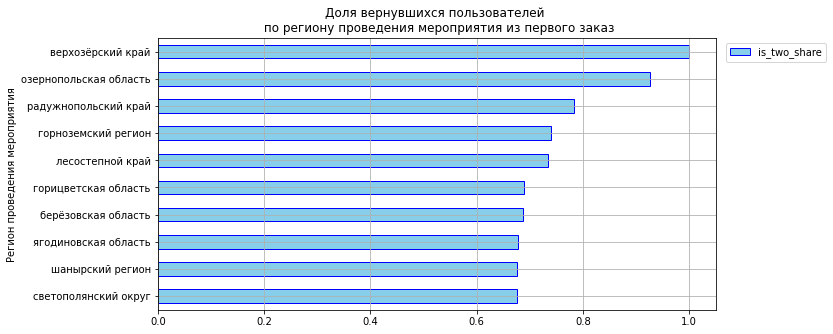

In [69]:
# Визуализируем долю вернувшихся пользователей по региону проведения мероприятия из первого заказ
grouped_region_view = grouped_region.sort_values(by='is_two_share', ascending=False).head(10)
grouped_region_view['is_two_share'].sort_values().plot(kind='barh',
                                           title=f'Доля вернувшихся пользователей \n по региону проведения мероприятия из первого заказ',
                                           color='skyblue',
                                           edgecolor='blue',
                                           legend=True,
                                           ylabel='',
                                           xlabel='Регион проведения мероприятия',
                                           rot=0,
                                           figsize=(10, 5))

plt.grid()
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

In [70]:
# Рассчитываем долю вернувшихся пользователей по билетному оператору, продавшему билеты на первый заказ
grouped_service = df_profile_filter.groupby(['first_service_name']).agg({'user_id': 'count',
                                                                     'is_two': 'sum'})
grouped_service['is_two_share'] = grouped_service['is_two'] / grouped_service['user_id']
grouped_service.sort_values(by='is_two_share', ascending=False)

,user_id,is_two,is_two_share
first_service_name,,,
зе бест!,1,1,1.000000
реестр,40,34,0.850000
быстрый кассир,60,51,0.850000
билет по телефону,5,4,0.800000
восьмёрка,82,58,0.707317
crazy ticket!,44,31,0.704545
дом культуры,344,232,0.674419
show_ticket,161,108,0.670807
край билетов,445,298,0.669663


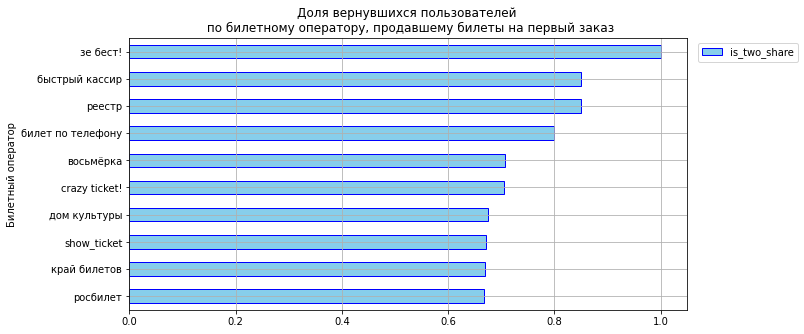

In [71]:
# Визуализируем долю вернувшихся пользователей по билетному оператору, продавшему билеты на первый заказ
grouped_service_view = grouped_service.sort_values(by='is_two_share', ascending=False).head(10)
grouped_service_view['is_two_share'].sort_values().plot(kind='barh',
                                           title=f'Доля вернувшихся пользователей \n по билетному оператору, продавшему билеты на первый заказ',
                                           color='skyblue',
                                           edgecolor='blue',
                                           legend=True,
                                           ylabel='',
                                           xlabel='Билетный оператор',
                                           rot=0,
                                           figsize=(10, 5))

plt.grid()
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

Чаще всего на Яндекс Афишу возвращаются пользователи:
- **по типу их первого мероприятия**: сделавшие заказ на покупку билетов в `театр` или на `выставку`(порядка 65% пользователей);

- **по типу устройства, с которого совершена первая покупка**: сделавшие заказ с `компьютера` (порядка 66% пользователей).

- **по региону проведения мероприятия из первого заказа**: регион проведения первого мероприятия - `Верхозёрский край` (100%, с учетом единичного пользователя и единичного повторного заказа) или `Озернопольская область`(порядка 93% пользователей).

- **по билетному оператору, продавшему билеты на первый заказ**: билетный оператор первого мероприятия `Зе бест!` (100%, с учетом единичного пользователя и единичного повторного заказа), `Быстрый кассир` или `Реестр` (порядка 85% пользователей)

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1** не является верной. Повторный заказ чаще совершают пользователи, оформившие свой первый заказ в театр или на выставку.

**Гипотеза 2** не является верной. Повторный заказ чаще совершают пользователи, посетившие первое мероприятие в малоактивном регионе - Верхозёрский край.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [72]:
# Импортируем библиотеку seaborn
import seaborn as sns

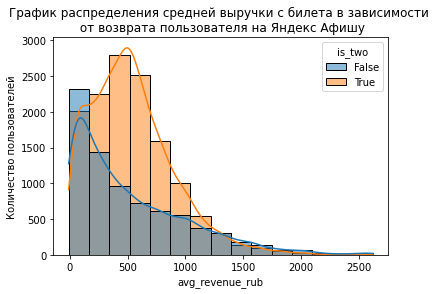

In [73]:
# Строим гистограмму распределния средней выручки с билета
sns.histplot(data=df_profile_filter, x='avg_revenue_rub', hue='is_two', bins=15, alpha=0.5, kde=True)

plt.title('График распределения средней выручки с билета в зависимости \n от возврата пользователя на Яндекс Афишу')
plt.ylabel('Количество пользователей')
plt.show()

Пользователи, совершившие только 1 заказ, концентрируются в диапазоне средней выручки - `150-200 рублей`, пользователи, которые совершили 2 и более заказов, концентрируются в диапазоне средней выручки - `~500 рублей`.

Количество пользователей, совершивших 2 и более заказов, практически на всех диапазонах средней выручки превышает количество пользователей с единственным заказом, за исключением минимального диапазона 0-170, а также в диапазонах выручки свыше 1500 рублей (являются выбросами).

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [74]:
# Фильтруем датафрейм по пользователям, которые совершили 2 и более заказов
df_order_2 = df_profile_filter[df_profile_filter['is_two']==True]

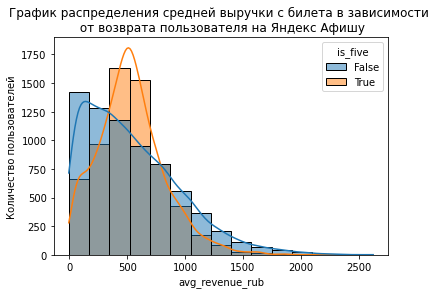

In [75]:
# Строим гистограмму распределния средней выручки с билета у пользователей,
# совершивших 2-4 заказа и пользователей, совершивших 5 и более заказов
sns.histplot(data=df_order_2, x='avg_revenue_rub', hue='is_five', bins=15, alpha=0.5, kde=True)

plt.title('График распределения средней выручки с билета в зависимости \n от возврата пользователя на Яндекс Афишу')
plt.ylabel('Количество пользователей')
plt.show()

Пользователи, совершившие 2-4 заказа, концентрируются в диапазоне средней выручки - `170-250 рублей`, пользователи, которые совершили 5 и более заказов, концентрируются в диапазоне средней выручки - `~500 рублей`.

Количество пользователей, совершивших 2-4 заказа, практически на всех диапазонах средней выручки превышает количество пользователей совершивших 5 и более заказов, за исключением диапазона 170-700 рублей.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [76]:
# Создаем столбец category_avg_tickets
# для категоризации пользователей по среднему количеству билетов в заказе
df_profile_filter = df_profile_filter.copy()
df_profile_filter['category_avg_tickets'] = pd.cut(df_profile_filter['avg_tickets_count'], bins=[0,2,3,5,100], labels=["1-2 билета","2-3 билета","3-5 билетов","5 и более билетов"])

# Подсчитываем количество пользователей для каждого сегмента и долю вернувшихся пользователей
df_avg_tickets = df_profile_filter.groupby(['category_avg_tickets']).agg({'user_id': 'count',
                                                                          'is_two': 'sum'})
df_avg_tickets['is_two'] = df_avg_tickets['is_two'] / df_avg_tickets['user_id']
df_avg_tickets.sort_values(by='is_two', ascending=False)

,user_id,is_two
category_avg_tickets,,
2-3 билета,10135,0.748397
3-5 билетов,4889,0.674780
1-2 билета,6163,0.401590
5 и более билетов,0,NaN


Пользователи распределены по сегментам неравномерно. Наибольшее количество пользователей имеют в заказах от 2 до 3 билетов, далее следуют пользователи с 1-2 билетами в заказе, на третьем месте - 3-5 билетов в заказе.

Вместе с тем, повторные покупки также совершают пользователи, у которых в заказе преимущественно 2-3 билета, далее 3-5 билетов, и на третьем месте - 1-2 билета в заказе.

`В моей выборке отсутствуют пользователи, в заказах которых свыше 5 билетов, так как на этапе формирования выборки, по показателю среднего количества билетов в заказе датафрейм был отфильтрован по 97 процентилю в связи с наличием выбросов`.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [77]:
# Создаем столбец first_day_week
# для категоризации пользователей по дню недели первого заказа
df_profile_filter['first_day_week'] = df_profile_filter['first_order_dt'].dt.day_of_week + 1

# Подсчитываем количество пользователей для каждого дня недели и долю вернувшихся пользователей
df_day_week = df_profile_filter.groupby(['first_day_week']).agg({'user_id': 'count',
                                                                 'is_two': 'sum'})
df_day_week['is_two_share'] = df_day_week['is_two'] / df_day_week['user_id']
df_day_week

,user_id,is_two,is_two_share
first_day_week,,,
1,2873,1845,0.642186
2,3071,1946,0.633670
3,2980,1901,0.637919
4,3030,1837,0.606271
5,3153,1934,0.613384
6,3356,2208,0.657926
7,2724,1688,0.619677


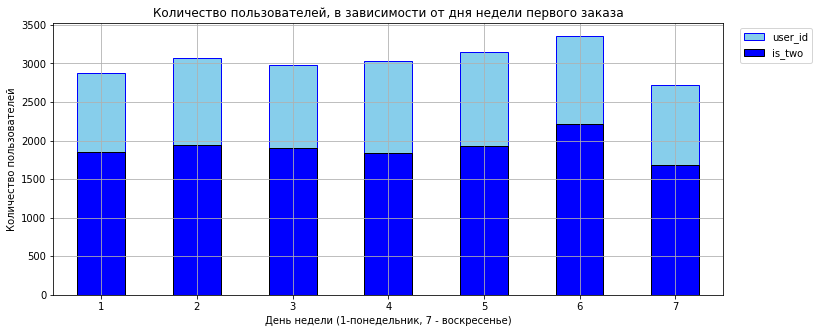

In [78]:
# Визуализируем долю пользователей, в т.ч. совершивших 2 и более заказов,
# в зависимости от дня недели первого заказа
df_day_week['user_id'].plot(kind='bar',
                    title=f'Количество пользователей, в зависимости от дня недели первого заказа',
                    color='skyblue',
                    edgecolor='blue',
                    legend=True,
                    ylabel='Количество пользователей',
                    xlabel='День недели (1-понедельник)',
                    rot=0,
                    figsize=(12, 5))

df_day_week['is_two'].plot(kind='bar',
                    color='blue',
                    edgecolor='black',
                    xlabel='День недели (1-понедельник, 7 - воскресенье)',
                    rot=0)


plt.grid()
plt.legend(bbox_to_anchor=(1.14, 1))
plt.show()

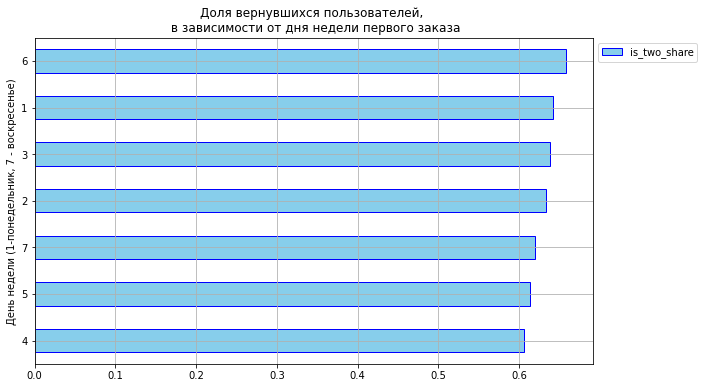

In [79]:
# Визуализируем долю вернувшихся пользователей в зависимости от дня недели первого заказа
df_day_week['is_two_share'].sort_values().plot(kind='barh',
                                               title=f'Доля вернувшихся пользователей, \n в зависимости от дня недели первого заказа',
                                               color='skyblue',
                                               edgecolor='blue',
                                               legend=True,
                                               xlabel='День недели (1-понедельник, 7 - воскресенье)',
                                               rot=0,
                                              figsize=(10, 6))
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Сильного изменения спроса в зависимости от дня недели не установлено. Наибольшее количество первых заказов совершается пользователями в субботу. Пользователи, сформировавшие несколько заказов, также совершают большинство заказов в субботу. При этом, объем сформированных заказов в воскресенье минимальный.

Повторно чаще возвращаются пользователи, совершившие первый заказ в субботy (66% пользователей) и в понедельник (~64% пользователей).

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [80]:
# Рассчитаем среднее время между заказами для пользователей, совершивших 2-4 заказа
avg_days_2 = df_profile_filter[(df_profile_filter['is_two']==True) & (df_profile_filter['is_five']==False)]['avg_days_since_prev'].mean().round(2)
f'Среднее время между заказми для пользователей, совершивших 2-4 заказа: {avg_days_2}.'

'Среднее время между заказми для пользователей, совершивших 2-4 заказа: 21.53.'

In [81]:
# Рассчитаем среднее время между заказами для пользователей, совершивших 5 и более заказов
avg_days_5 = df_profile_filter[df_profile_filter['is_five']==True]['avg_days_since_prev'].mean().round(2)
f'Среднее время между заказми для пользователей, совершивших 5 и более заказов: {avg_days_5}.'

'Среднее время между заказми для пользователей, совершивших 5 и более заказов: 9.6.'

Пользователи, у которых короче время между повторными заказами, чаще возвращаются на платформу за новым заказом.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [82]:
# Устанавливаем библиотеку phik
!pip install phik

In [83]:
# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [84]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df_profile_filter[['first_order_dt', 'last_order_dt', 'first_device_type',
       'first_region', 'first_service_name', 'first_event_type', 'order_count',
       'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev', 'is_two',
       'is_five']].phik_matrix(interval_cols=['order_count', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev'])
correlation_matrix

,first_order_dt,last_order_dt,first_device_type,first_region,first_service_name,first_event_type,order_count,avg_revenue_rub,avg_tickets_count,avg_days_since_prev,is_two,is_five
first_order_dt,1.000000,0.998668,0.104424,0.477699,0.294933,0.259986,0.153928,0.259998,0.363073,0.332700,0.420513,0.558569
last_order_dt,0.998668,1.000000,0.079819,0.342429,0.207702,0.152968,0.000000,0.266946,0.362197,0.199941,0.459170,0.587918
first_device_type,0.104424,0.079819,1.000000,0.115503,0.080856,0.061257,0.000000,0.075061,0.055901,0.015508,0.038281,0.043504
first_region,0.477699,0.342429,0.115503,1.000000,0.697251,0.510344,0.110403,0.358508,0.135202,0.078993,0.083318,0.089424
first_service_name,0.294933,0.207702,0.080856,0.697251,1.000000,0.586984,0.100794,0.380636,0.092173,0.052869,0.051460,0.069786
first_event_type,0.259986,0.152968,0.061257,0.510344,0.586984,1.000000,0.000000,0.328720,0.083604,0.049603,0.023529,0.025908
order_count,0.153928,0.000000,0.000000,0.110403,0.100794,0.000000,1.000000,0.000000,0.060273,0.000000,0.033912,0.077371
avg_revenue_rub,0.259998,0.266946,0.075061,0.358508,0.380636,0.328720,0.000000,1.000000,0.478061,0.089296,0.316006,0.350740
avg_tickets_count,0.363073,0.362197,0.055901,0.135202,0.092173,0.083604,0.060273,0.478061,1.000000,0.173334,0.799689,0.643906
avg_days_since_prev,0.332700,0.199941,0.015508,0.078993,0.052869,0.049603,0.000000,0.089296,0.173334,1.000000,0.091633,0.476038


In [85]:
# Выводим результат для переменной order_count
print('Корреляционная матрица с коэффициентом phi_k для переменной order_count')
matrix_heatmap = correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)
matrix_heatmap

Корреляционная матрица с коэффициентом phi_k для переменной order_count


,order_count
first_order_dt,0.153928
first_region,0.110403
first_service_name,0.100794
is_five,0.077371
avg_tickets_count,0.060273
is_two,0.033912
last_order_dt,0.000000
first_device_type,0.000000
first_event_type,0.000000
avg_revenue_rub,0.000000


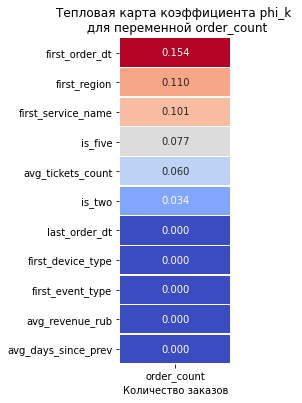

In [86]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака churn с другими признаками клиента
sns.heatmap(matrix_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.3f', # Форматируем значения корреляции: три знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для переменной order_count')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

In [87]:
# Выделяем сегменты по количеству заказов
df_profile_filter['order_count_1'] = pd.cut(df_profile_filter['order_count'], bins=[0,1,4,15000], labels=["1","2","3"])
count = df_profile_filter.groupby(['order_count_1'])['user_id'].count()
count

order_count_1
1    7828
2    7035
3    6324
Name: user_id, dtype: int64

In [88]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix_1 = df_profile_filter[['first_order_dt', 'last_order_dt', 'first_device_type',
       'first_region', 'first_service_name', 'first_event_type', 'order_count_1',
       'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev', 'is_two',
       'is_five']].phik_matrix(interval_cols=['order_count_1', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev'])
correlation_matrix_1

,first_order_dt,last_order_dt,first_device_type,first_region,first_service_name,first_event_type,order_count_1,avg_revenue_rub,avg_tickets_count,avg_days_since_prev,is_two,is_five
first_order_dt,1.000000,0.998668,0.104424,0.477699,0.294933,0.259986,0.593775,0.259998,0.363073,0.332700,0.420513,0.558569
last_order_dt,0.998668,1.000000,0.079819,0.342429,0.207702,0.152968,0.621157,0.266946,0.362197,0.199941,0.459170,0.587918
first_device_type,0.104424,0.079819,1.000000,0.115503,0.080856,0.061257,0.017999,0.075061,0.055901,0.015508,0.038281,0.043504
first_region,0.477699,0.342429,0.115503,1.000000,0.697251,0.510344,0.128701,0.358508,0.135202,0.078993,0.083318,0.089424
first_service_name,0.294933,0.207702,0.080856,0.697251,1.000000,0.586984,0.083317,0.380636,0.092173,0.052869,0.051460,0.069786
first_event_type,0.259986,0.152968,0.061257,0.510344,0.586984,1.000000,0.036925,0.328720,0.083604,0.049603,0.023529,0.025908
order_count_1,0.593775,0.621157,0.017999,0.128701,0.083317,0.036925,1.000000,0.332921,0.662003,0.399994,1.000000,1.000000
avg_revenue_rub,0.259998,0.266946,0.075061,0.358508,0.380636,0.328720,0.332921,1.000000,0.478061,0.089296,0.316006,0.350740
avg_tickets_count,0.363073,0.362197,0.055901,0.135202,0.092173,0.083604,0.662003,0.478061,1.000000,0.173334,0.799689,0.643906
avg_days_since_prev,0.332700,0.199941,0.015508,0.078993,0.052869,0.049603,0.399994,0.089296,0.173334,1.000000,0.091633,0.476038


In [89]:
# Выводим результат для переменной order_count
print('Корреляционная матрица с коэффициентом phi_k \n для категориальной переменной order_count_1')
matrix_heatmap_1 = correlation_matrix_1.loc[correlation_matrix_1.index != 'order_count_1'][['order_count_1']].sort_values(by='order_count_1', ascending=False)
matrix_heatmap_1

Корреляционная матрица с коэффициентом phi_k 
 для категориальной переменной order_count_1


,order_count_1
is_two,1.000000
is_five,1.000000
avg_tickets_count,0.662003
last_order_dt,0.621157
first_order_dt,0.593775
avg_days_since_prev,0.399994
avg_revenue_rub,0.332921
first_region,0.128701
first_service_name,0.083317
first_event_type,0.036925


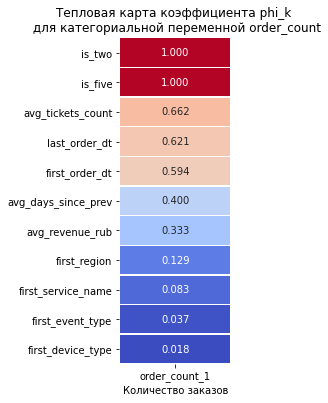

In [90]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака churn с другими признаками клиента
sns.heatmap(matrix_heatmap_1,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.3f', # Форматируем значения корреляции: три знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для категориальной переменной order_count')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

Наиболее связаны с количеством заказов следующие признаки:
- среднее количество билетов в заказе (phi_k = 0,662);
- дата последнего заказа (phi_k = 0,621);
- дата первого заказа (phi_k = 0,594);
- средний период между заказами (phi_k = 0,400);
- средняя выручка от заказов (phi_k = 0,333)

Признаки `is_two`,`is_five` коррелируют  с количеством заказов - 1, так как на основании количества заказа данные признаки и были сформированы.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Первоначальный датафрейм** содержал информацию о **290611 заказах 21933 уникальных пользователей**, данные были выгружены с учетом фильтрации по типу устройства, с которого создавались заказы (компьютер и мобильный телефон), а также исключен тип мероприятия фильмы, в связи с ограниченным объемом информации.
В процессе анализа первоначальных данных была проведена конвертация выручки, выраженной в казахстанских тенге в российские рубли, и проведена фильтрация по 99 процентилю по размеру выручки с заказа.

Сформирован профиль пользователя на основе данных первого заказа каждого уникального пользователя, а также средних данных о всех заказах каждого уникального пользователя. По результатам анализа профиля пользователя в связи с наличем выбросов, была проведена фильтрация по 97 процентилю по среднему количеству билетов в заказе. **Итоговый аналитический датафрейм** содержит информацию о **21187 уникальных пользователях и 286697 заказах**.

Среднее количество заказов пользователя равно 13, при этом медиана равна 2. Выявлен один пользователь, сформировавший 10175 заказов (наиболее существенный выброс, который влияет на среднее значение).
Среднее количество билетов в заказе - ~3 (выбросы были отфильтрованы).

Вероятность возврата пользователей на Яндекс Афишу может быть выше, при наличии следующих факторов в первом заказе:
- тип мероприятия - театр или выставка;
- заказ сделан с компьютера;
- регион проведения первого мероприятия - Верхозёрский край или Озернопольская область (малоактивные регионы);
- билетный оператор - Зе бест!, Быстрый кассир или Реестр.

Большее количество заказов у пользователя характеризуется большей величиной средней выручки. Пользователи, с количеством заказов до 4 концентрируются в диапазоне средней выручки - 150-250 рублей, при этом пользователи, которые совершили 5 и более заказов, концентрируются в диапазоне средней выручки - ~500 рублей.

Повторные покупки чаще совершают пользователи имеющие в заказах от 2 до 3 билетов (75% пользователей совершили повторный заказ).

Наибольшее количество первых заказов совершается пользователями в субботу, наименьшее - в воскресенье. Повторно чаще возвращаются пользователи, совершившие первый заказ в субботy (66% пользователей) и в понедельник (~64% пользователей).

Короткий период между предыдущим и следующим заказом может свидетельствовать о возрате пользователя. Среднее время между заказми для пользователей, совершивших 2-4 заказа составляет ~22 дня, для пользователей совершившиз 5 и более заказов - ~10 дней.

Наиболее связаны с количеством заказов следующие признаки:
- среднее количество билетов в заказе;
- дата последнего заказа;
- дата первого заказа.

**Рекомендации**

С учетом факторов, выявленных в результате анализа, в целях удержания постоянных клиентов возможно обратить внимание на следующее:
- на пользователей, совершающих заказы с мобильного телефона, так как данные пользователи составляют основной объем заказов, при этом доля повторных возвратов по ним ниже, чем у пользователей, создающих заказ с компьютера;


- на популярные регионы проведения мероприятий (Каменевский регион, Североярская область), поскольку повторные заказы на мероприятия в данных регионах совершаются реже, чем в непопулярных регионах;


- на популярных билетных операторов (Билеты без проблем, Мой билет, Лови билет!), поскольку повторные заказы на мероприятия через данных операторов совершаются реже, чем через непопулярных операторов;


- в целях увеличения объема продаж в непопулярные дни недели, например, в воскресенье, возможно проведение маркетинговых акций.


- возможно проведение акций или предоставление скидок в течении недели после предыдущей покупки, в целях сокращения времени между заказами и возвратом пользователя на площадку.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**